In [1]:
# ============================================================
# 📦 INSTALL DEPENDENCIES
# ============================================================
!pip install transformers datasets torch torchvision torchaudio
!pip install nltk Sastrawi scikit-learn pandas matplotlib seaborn


                                          clean_text inset_sentiment
0  cuma jadi komoditas politik enginer malah di p...         negatif
1  pepetah tahun ini vaksin hilang mobil dan moto...         negatif
2   kalo mobil pertama ya jgn langsung mobil listrik         positif
3  iya tau kan pemerintah kita suka ga konsisten ...         negatif
4  harapannya dengan pasokan listrik ini hasil pr...         positif
inset_sentiment
negatif    4707
positif    4707
netral     3044
Name: count, dtype: int64
Label mapping: {'negatif': np.int64(0), 'netral': np.int64(1), 'positif': np.int64(2)}


Epoch 1/10 - Validation: 100%|██████████| 78/78 [00:16<00:00,  4.77it/s]



📊 Epoch [1/10]
Train Loss: 1.1158, Train Acc: 0.4284
Val Loss:   0.9974, Val Acc:   0.5269


Epoch 2/10 - Validation: 100%|██████████| 78/78 [00:16<00:00,  4.80it/s]



📊 Epoch [2/10]
Train Loss: 1.0475, Train Acc: 0.4841
Val Loss:   0.9837, Val Acc:   0.5297


Epoch 3/10 - Validation: 100%|██████████| 78/78 [00:16<00:00,  4.77it/s]



📊 Epoch [3/10]
Train Loss: 1.0218, Train Acc: 0.5031
Val Loss:   0.9702, Val Acc:   0.5437


Epoch 4/10 - Validation: 100%|██████████| 78/78 [00:16<00:00,  4.75it/s]



📊 Epoch [4/10]
Train Loss: 1.0013, Train Acc: 0.5220
Val Loss:   0.9666, Val Acc:   0.5474


Epoch 5/10 - Validation: 100%|██████████| 78/78 [00:16<00:00,  4.78it/s]



📊 Epoch [5/10]
Train Loss: 0.9758, Train Acc: 0.5311
Val Loss:   0.9487, Val Acc:   0.5598


Epoch 6/10 - Validation: 100%|██████████| 78/78 [00:16<00:00,  4.76it/s]



📊 Epoch [6/10]
Train Loss: 0.9663, Train Acc: 0.5359
Val Loss:   0.9459, Val Acc:   0.5618


Epoch 7/10 - Validation: 100%|██████████| 78/78 [00:16<00:00,  4.78it/s]



📊 Epoch [7/10]
Train Loss: 0.9508, Train Acc: 0.5526
Val Loss:   0.9459, Val Acc:   0.5622


Epoch 8/10 - Validation: 100%|██████████| 78/78 [00:16<00:00,  4.77it/s]



📊 Epoch [8/10]
Train Loss: 0.9379, Train Acc: 0.5626
Val Loss:   0.9417, Val Acc:   0.5642


Epoch 9/10 - Validation: 100%|██████████| 78/78 [00:16<00:00,  4.78it/s]



📊 Epoch [9/10]
Train Loss: 0.9244, Train Acc: 0.5650
Val Loss:   0.9361, Val Acc:   0.5686


Epoch 10/10 - Validation: 100%|██████████| 78/78 [00:16<00:00,  4.77it/s]



📊 Epoch [10/10]
Train Loss: 0.9170, Train Acc: 0.5713
Val Loss:   0.9342, Val Acc:   0.5706


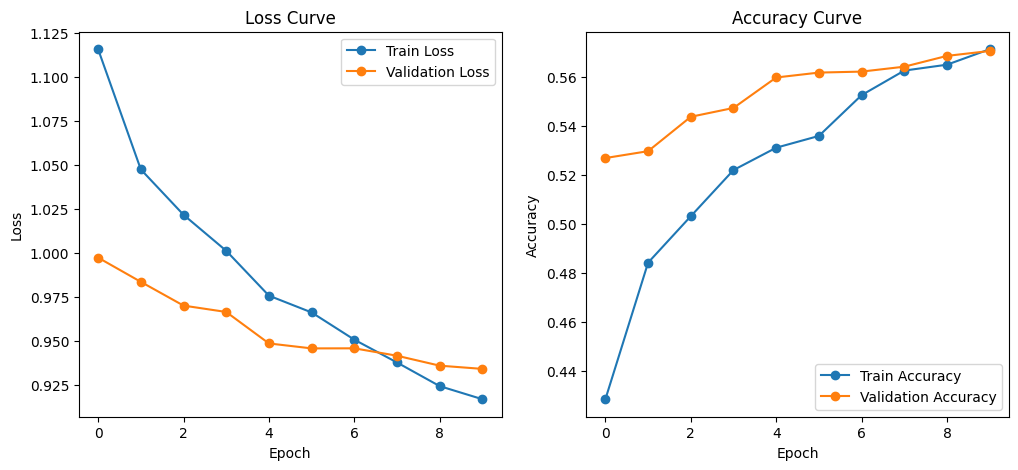


📋 Classification Report:
              precision    recall  f1-score   support

     negatif       0.57      0.74      0.65       942
      netral       0.38      0.16      0.23       609
     positif       0.61      0.67      0.64       941

    accuracy                           0.57      2492
   macro avg       0.52      0.52      0.50      2492
weighted avg       0.54      0.57      0.54      2492



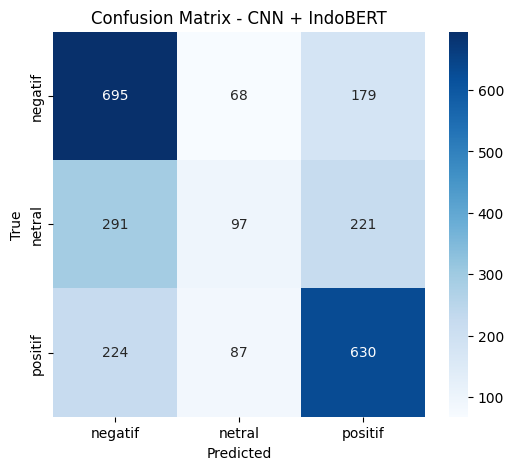

In [2]:

# ============================================================
# 📚 IMPORT LIBRARIES
# ============================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
from tqdm import tqdm

# ============================================================
# 🧹 LOAD DATASET
# ============================================================
df = pd.read_csv('/content/drive/MyDrive/bersih_cleaned_text_Sentimentlabeled_updated.csv')
print(df.head())
print(df['inset_sentiment'].value_counts())

# ============================================================
# 🏷️ LABEL ENCODING
# ============================================================
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['inset_sentiment'])
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_map)

# ============================================================
# 🔀 TRAIN-TEST SPLIT
# ============================================================
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# ============================================================
# 🤖 LOAD TRANSFORMER (IndoBERTweet)
# ============================================================
# MODEL_NAME = "indobenchmark/indobertweet-base"
MODEL_NAME = "indolem/indobertweet-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

# ============================================================
# 📦 DATASET CLASS
# ============================================================
class IndoBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        encoding = self.tokenizer(
            text, truncation=True, padding='max_length',
            max_length=self.max_len, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

# ============================================================
# ⚙️ DATALOADERS
# ============================================================
BATCH_SIZE = 32
train_dataset = IndoBERTDataset(train_texts, train_labels, tokenizer)
val_dataset   = IndoBERTDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ============================================================
# 🧠 MODEL (CNN + IndoBERT)
# ============================================================
class CNN_IndoBERT(nn.Module):
    def __init__(self, bert_model, num_classes=3):
        super(CNN_IndoBERT, self).__init__()
        self.bert = bert_model
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=768, out_channels=256, kernel_size=k)
            for k in [2, 3, 4]
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256 * len([2, 3, 4]), num_classes)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # freeze BERT
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = bert_output.last_hidden_state  # [batch, seq_len, hidden]
        x = last_hidden_state.permute(0, 2, 1)  # [batch, hidden, seq_len]
        conv_outs = [torch.relu(conv(x)) for conv in self.convs]
        pooled = [torch.max(c_out, dim=2)[0] for c_out in conv_outs]
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        return self.fc(cat)

# ============================================================
# 🧩 TRAINING SETUP
# ============================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_IndoBERT(bert_model).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 10  # you can increase later if GPU allows

# ============================================================
# 📈 TRAINING + VALIDATION LOOP (tracks metrics)
# ============================================================
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    # ----- TRAIN -----
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # ----- VALIDATION -----
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"\n📊 Epoch [{epoch+1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")
    print("=" * 60)

# ============================================================
# 📊 LEARNING CURVES
# ============================================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(val_accs, label='Validation Accuracy', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# ============================================================
# 🧪 FINAL EVALUATION ON VALIDATION SET
# ============================================================
model.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)
        preds.extend(predictions.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

print("\n📋 Classification Report:")
print(classification_report(true_labels, preds, target_names=label_encoder.classes_))

# ============================================================
# 🔢 CONFUSION MATRIX
# ============================================================
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN + IndoBERT")
plt.show()


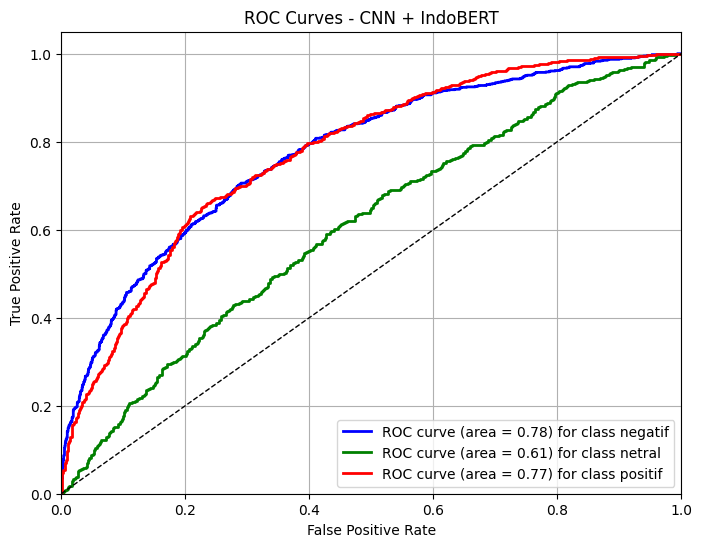


AUC SCORES per class:
negatif: 0.7761
netral: 0.6072
positif: 0.7749
Micro-average AUC: 0.7422


In [17]:
# ============================================================
# 📈 ROC CURVES & AUC SCORES (for multi-class classification)
# ============================================================
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Convert labels to one-hot (needed for multi-class ROC)
true_labels_bin = label_binarize(true_labels, classes=[0, 1, 2])  # 0=negatif,1=netral,2=positif

# Get model probabilities for ROC curves
model.eval()
probs = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask)
        probabilities = torch.softmax(outputs, dim=1)
        probs.extend(probabilities.cpu().numpy())

probs = np.array(probs)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(true_labels_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# ============================================================
# 🎨 PLOT ROC CURVES
# ============================================================
plt.figure(figsize=(8,6))
colors = cycle(['blue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {label_encoder.classes_[i]}')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - CNN + IndoBERT')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# ============================================================
# 🧾 PRINT AUC SCORES
# ============================================================
print("\nAUC SCORES per class:")
for i in range(n_classes):
    print(f"{label_encoder.classes_[i]}: {roc_auc[i]:.4f}")
print(f"Micro-average AUC: {roc_auc['micro']:.4f}")
